# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params

params = get_params()

In [3]:
from epftoolbox.evaluation import DM, GW, plot_multivariate_GW_test, plot_multivariate_DM_test

# note: to install this package, execute
    #git clone https://github.com/jeslago/epftoolbox.git
    #cd epftoolbox
    #pip install .
# may also need to modify epftoolbox/setup.py to be able to install it after python 3.11
# files may be inside C:\Users\{user}\epftoolbox

In [39]:
dataroute = os.path.join("..", "data")
dumproute = os.path.join("..", "dump")
resultsroute = os.path.join("..", "results")
graphsroute = os.path.join(resultsroute, "graphs")

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)

In [7]:
def get_all_results_matching(substring:str):
    all_results = {}

    for filename in os.listdir(resultsroute):
        file_path = os.path.join(resultsroute, filename)
        if os.path.isfile(file_path) and substring in filename:
            all_results[filename] = file_path

    print(all_results)
    return all_results

In [8]:
all_forecasts = get_all_results_matching("forecast")
all_residuals = get_all_results_matching("residual")

{'GARCH_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\GARCH_AR_^MERV_aic_best_forecasts.pickle', 'GARCH_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\GARCH_AR_^MERV_bic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\HMM_multiv_AR_^MERV_aic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\HMM_multiv_AR_^MERV_bic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\HMM_univ_AR_^MERV_aic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\HMM_univ_AR_^MERV_bic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle', 'VAR_multiv_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\VAR_multiv_AR_^MERV_aic_best_forecasts.pickle', 'VAR_multiv_AR_^MERV

In [9]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [10]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = (
                name.replace(f"{substring_to_replace}.pickle", "")
                .replace("best", "")
                .replace(params["tablename"], "")
                .replace("__", "_")
                .replace("__", "_")
            )

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [11]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")
forecasts_df.head(2)

GARCH_AR_^MERV_aic_best_forecasts.pickle
GARCH_AR_^MERV_bic_best_forecasts.pickle
HMM_multiv_AR_^MERV_aic_best_forecasts.pickle
HMM_multiv_AR_^MERV_bic_best_forecasts.pickle
HMM_univ_AR_^MERV_aic_best_forecasts.pickle
HMM_univ_AR_^MERV_bic_best_forecasts.pickle
HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle
HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle
VAR_multiv_AR_^MERV_aic_best_forecasts.pickle
VAR_multiv_AR_^MERV_bic_best_forecasts.pickle
VAR_with_vol_AR_^MERV_aic_best_forecasts.pickle
VAR_with_vol_AR_^MERV_bic_best_forecasts.pickle


,GARCH_aic__^MERV,GARCH_aic__GGAL.BA,GARCH_aic__GGAL,GARCH_aic__YPFD.BA,GARCH_aic__YPF,GARCH_aic__EDN.BA,GARCH_aic__EDN,GARCH_aic__BMA.BA,GARCH_aic__BMA,GARCH_aic__BBAR.BA,GARCH_aic__BBAR,GARCH_bic__^MERV,GARCH_bic__GGAL.BA,GARCH_bic__GGAL,GARCH_bic__YPFD.BA,GARCH_bic__YPF,GARCH_bic__EDN.BA,GARCH_bic__EDN,GARCH_bic__BMA.BA,GARCH_bic__BMA,GARCH_bic__BBAR.BA,GARCH_bic__BBAR,HMM_multiv_aic__^MERV,HMM_multiv_aic__GGAL.BA,HMM_multiv_aic__GGAL,HMM_multiv_aic__YPFD.BA,HMM_multiv_aic__YPF,HMM_multiv_aic__EDN.BA,HMM_multiv_aic__EDN,HMM_multiv_aic__BMA.BA,HMM_multiv_aic__BMA,HMM_multiv_aic__BBAR.BA,HMM_multiv_aic__BBAR,HMM_multiv_bic__^MERV,HMM_multiv_bic__GGAL.BA,HMM_multiv_bic__GGAL,HMM_multiv_bic__YPFD.BA,HMM_multiv_bic__YPF,HMM_multiv_bic__EDN.BA,HMM_multiv_bic__EDN,HMM_multiv_bic__BMA.BA,HMM_multiv_bic__BMA,HMM_multiv_bic__BBAR.BA,HMM_multiv_bic__BBAR,HMM_univ_aic__^MERV,HMM_univ_aic__GGAL.BA,HMM_univ_aic__GGAL,HMM_univ_aic__YPFD.BA,HMM_univ_aic__YPF,HMM_univ_aic__EDN.BA,HMM_univ_aic__EDN,HMM_univ_aic__BMA.BA,HMM_univ_aic__BMA,HMM_univ_aic__BBAR.BA,HMM_univ_aic__BBAR,HMM_univ_bic__^MERV,HMM_univ_bic__GGAL.BA,HMM_univ_bic__GGAL,HMM_univ_bic__YPFD.BA,HMM_univ_bic__YPF,HMM_univ_bic__EDN.BA,HMM_univ_bic__EDN,HMM_univ_bic__BMA.BA,HMM_univ_bic__BMA,HMM_univ_bic__BBAR.BA,HMM_univ_bic__BBAR,HMM_with_vol_aic__^MERV,HMM_with_vol_aic__GGAL.BA,HMM_with_vol_aic__GGAL,HMM_with_vol_aic__YPFD.BA,HMM_with_vol_aic__YPF,HMM_with_vol_aic__EDN.BA,HMM_with_vol_aic__EDN,HMM_with_vol_aic__BMA.BA,HMM_with_vol_aic__BMA,HMM_with_vol_aic__BBAR.BA,HMM_with_vol_aic__BBAR,HMM_with_vol_bic__^MERV,HMM_with_vol_bic__GGAL.BA,HMM_with_vol_bic__GGAL,HMM_with_vol_bic__YPFD.BA,HMM_with_vol_bic__YPF,HMM_with_vol_bic__EDN.BA,HMM_with_vol_bic__EDN,HMM_with_vol_bic__BMA.BA,HMM_with_vol_bic__BMA,HMM_with_vol_bic__BBAR.BA,HMM_with_vol_bic__BBAR,VAR_multiv_aic__^MERV,VAR_multiv_aic__GGAL.BA,VAR_multiv_aic__GGAL,VAR_multiv_aic__YPFD.BA,VAR_multiv_aic__YPF,VAR_multiv_aic__EDN.BA,VAR_multiv_aic__EDN,VAR_multiv_aic__BMA.BA,VAR_multiv_aic__BMA,VAR_multiv_aic__BBAR.BA,VAR_multiv_aic__BBAR,VAR_multiv_bic__^MERV,VAR_multiv_bic__GGAL.BA,VAR_multiv_bic__GGAL,VAR_multiv_bic__YPFD.BA,VAR_multiv_bic__YPF,VAR_multiv_bic__EDN.BA,VAR_multiv_bic__EDN,VAR_multiv_bic__BMA.BA,VAR_multiv_bic__BMA,VAR_multiv_bic__BBAR.BA,VAR_multiv_bic__BBAR,VAR_with_vol_aic__^MERV,VAR_with_vol_aic__GGAL.BA,VAR_with_vol_aic__GGAL,VAR_with_vol_aic__YPFD.BA,VAR_with_vol_aic__YPF,VAR_with_vol_aic__EDN.BA,VAR_with_vol_aic__EDN,VAR_with_vol_aic__BMA.BA,VAR_with_vol_aic__BMA,VAR_with_vol_aic__BBAR.BA,VAR_with_vol_aic__BBAR,VAR_with_vol_bic__^MERV,VAR_with_vol_bic__GGAL.BA,VAR_with_vol_bic__GGAL,VAR_with_vol_bic__YPFD.BA,VAR_with_vol_bic__YPF,VAR_with_vol_bic__EDN.BA,VAR_with_vol_bic__EDN,VAR_with_vol_bic__BMA.BA,VAR_with_vol_bic__BMA,VAR_with_vol_bic__BBAR.BA,VAR_with_vol_bic__BBAR
2023-06-01,0.006464,0.003662,0.002645,0.008487,0.004440,0.008652,-0.000993,0.003256,-0.000135,0.005759,0.001840,0.006464,0.003929,0.002719,0.008337,0.004196,0.008652,-0.001204,0.002898,-0.000152,0.005987,0.001814,NaN,0.005035,NaN,0.006915,0.003978,NaN,0.001715,0.003624,NaN,NaN,0.001957,NaN,0.005035,0.001568,0.006915,0.003978,NaN,0.001715,0.003624,0.001281,NaN,0.001957,0.005691,0.003695,0.001749,0.007938,0.002818,0.017306,0.001811,0.003097,0.001915,0.003912,0.002321,0.005691,0.002319,0.001749,0.007544,0.002818,0.006885,0.002619,0.003097,0.000191,0.003912,0.001466,0.005429,0.005197,0.001571,0.006915,0.003978,0.005376,0.004389,0.004688,0.001281,0.005251,0.001951,0.005834,0.005197,0.001568,0.006915,0.003978,0.005376,0.004389,0.004688,0.001281,0.005250,0.001951,0.00019,0.011170,-0.007891,0.009568,0.002968,0.001196,-0.004136,-0.038366,-0.023599,-0.031229,-0.017275,0.002074,0.002612,0.002179,0.001047,0.003000,0.006174,0.000013,-0.001931,-0.001257,-0.001394,-0.002392,0.004813,0.016648,-0.007634,0.001170,-0.000505,0.001122,0.002737,-0.014572,-0.007289,-0.005403,-0.006371,0.004117,0.004146,0.002526,0.002763,0.003393,0.004330,-0.000316,0.003754,0.000073,

In [12]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")
residual_df.head(2)

GARCH_AR_^MERV_aic_best_residuals.pickle
GARCH_AR_^MERV_bic_best_residuals.pickle
HMM_multiv_AR_^MERV_aic_best_residuals.pickle
HMM_multiv_AR_^MERV_bic_best_residuals.pickle
HMM_univ_AR_^MERV_aic_best_residuals.pickle
HMM_univ_AR_^MERV_bic_best_residuals.pickle
HMM_with_vol_AR_^MERV_aic_best_residuals.pickle
HMM_with_vol_AR_^MERV_bic_best_residuals.pickle
VAR_multiv_AR_^MERV_aic_best_residuals.pickle
VAR_multiv_AR_^MERV_bic_best_residuals.pickle
VAR_with_vol_AR_^MERV_aic_best_residuals.pickle
VAR_with_vol_AR_^MERV_bic_best_residuals.pickle


,GARCH_aic__^MERV,GARCH_aic__GGAL.BA,GARCH_aic__GGAL,GARCH_aic__YPFD.BA,GARCH_aic__YPF,GARCH_aic__EDN.BA,GARCH_aic__EDN,GARCH_aic__BMA.BA,GARCH_aic__BMA,GARCH_aic__BBAR.BA,GARCH_aic__BBAR,GARCH_bic__^MERV,GARCH_bic__GGAL.BA,GARCH_bic__GGAL,GARCH_bic__YPFD.BA,GARCH_bic__YPF,GARCH_bic__EDN.BA,GARCH_bic__EDN,GARCH_bic__BMA.BA,GARCH_bic__BMA,GARCH_bic__BBAR.BA,GARCH_bic__BBAR,HMM_multiv_aic__^MERV,HMM_multiv_aic__GGAL.BA,HMM_multiv_aic__GGAL,HMM_multiv_aic__YPFD.BA,HMM_multiv_aic__YPF,HMM_multiv_aic__EDN.BA,HMM_multiv_aic__EDN,HMM_multiv_aic__BMA.BA,HMM_multiv_aic__BMA,HMM_multiv_aic__BBAR.BA,HMM_multiv_aic__BBAR,HMM_multiv_bic__^MERV,HMM_multiv_bic__GGAL.BA,HMM_multiv_bic__GGAL,HMM_multiv_bic__YPFD.BA,HMM_multiv_bic__YPF,HMM_multiv_bic__EDN.BA,HMM_multiv_bic__EDN,HMM_multiv_bic__BMA.BA,HMM_multiv_bic__BMA,HMM_multiv_bic__BBAR.BA,HMM_multiv_bic__BBAR,HMM_univ_aic__^MERV,HMM_univ_aic__GGAL.BA,HMM_univ_aic__GGAL,HMM_univ_aic__YPFD.BA,HMM_univ_aic__YPF,HMM_univ_aic__EDN.BA,HMM_univ_aic__EDN,HMM_univ_aic__BMA.BA,HMM_univ_aic__BMA,HMM_univ_aic__BBAR.BA,HMM_univ_aic__BBAR,HMM_univ_bic__^MERV,HMM_univ_bic__GGAL.BA,HMM_univ_bic__GGAL,HMM_univ_bic__YPFD.BA,HMM_univ_bic__YPF,HMM_univ_bic__EDN.BA,HMM_univ_bic__EDN,HMM_univ_bic__BMA.BA,HMM_univ_bic__BMA,HMM_univ_bic__BBAR.BA,HMM_univ_bic__BBAR,HMM_with_vol_aic__^MERV,HMM_with_vol_aic__GGAL.BA,HMM_with_vol_aic__GGAL,HMM_with_vol_aic__YPFD.BA,HMM_with_vol_aic__YPF,HMM_with_vol_aic__EDN.BA,HMM_with_vol_aic__EDN,HMM_with_vol_aic__BMA.BA,HMM_with_vol_aic__BMA,HMM_with_vol_aic__BBAR.BA,HMM_with_vol_aic__BBAR,HMM_with_vol_bic__^MERV,HMM_with_vol_bic__GGAL.BA,HMM_with_vol_bic__GGAL,HMM_with_vol_bic__YPFD.BA,HMM_with_vol_bic__YPF,HMM_with_vol_bic__EDN.BA,HMM_with_vol_bic__EDN,HMM_with_vol_bic__BMA.BA,HMM_with_vol_bic__BMA,HMM_with_vol_bic__BBAR.BA,HMM_with_vol_bic__BBAR,VAR_multiv_aic__^MERV,VAR_multiv_aic__GGAL.BA,VAR_multiv_aic__GGAL,VAR_multiv_aic__YPFD.BA,VAR_multiv_aic__YPF,VAR_multiv_aic__EDN.BA,VAR_multiv_aic__EDN,VAR_multiv_aic__BMA.BA,VAR_multiv_aic__BMA,VAR_multiv_aic__BBAR.BA,VAR_multiv_aic__BBAR,VAR_multiv_bic__^MERV,VAR_multiv_bic__GGAL.BA,VAR_multiv_bic__GGAL,VAR_multiv_bic__YPFD.BA,VAR_multiv_bic__YPF,VAR_multiv_bic__EDN.BA,VAR_multiv_bic__EDN,VAR_multiv_bic__BMA.BA,VAR_multiv_bic__BMA,VAR_multiv_bic__BBAR.BA,VAR_multiv_bic__BBAR,VAR_with_vol_aic__^MERV,VAR_with_vol_aic__GGAL.BA,VAR_with_vol_aic__GGAL,VAR_with_vol_aic__YPFD.BA,VAR_with_vol_aic__YPF,VAR_with_vol_aic__EDN.BA,VAR_with_vol_aic__EDN,VAR_with_vol_aic__BMA.BA,VAR_with_vol_aic__BMA,VAR_with_vol_aic__BBAR.BA,VAR_with_vol_aic__BBAR,VAR_with_vol_bic__^MERV,VAR_with_vol_bic__GGAL.BA,VAR_with_vol_bic__GGAL,VAR_with_vol_bic__YPFD.BA,VAR_with_vol_bic__YPF,VAR_with_vol_bic__EDN.BA,VAR_with_vol_bic__EDN,VAR_with_vol_bic__BMA.BA,VAR_with_vol_bic__BMA,VAR_with_vol_bic__BBAR.BA,VAR_with_vol_bic__BBAR
2023-06-01,0.026022,0.021342,0.015719,0.031394,0.023377,0.046265,0.034434,0.055354,0.043050,0.037687,0.034039,0.026022,0.021076,0.015646,0.031544,0.023621,0.046265,0.034645,0.055711,0.043068,0.037458,0.034064,NaN,0.019969,NaN,0.032966,0.023839,NaN,0.031726,0.054985,NaN,NaN,0.033922,NaN,0.019969,0.016796,0.032966,0.023839,NaN,0.031726,0.054985,0.041634,NaN,0.033922,0.026794,0.021309,0.016615,0.031943,0.024999,0.037611,0.031630,0.055512,0.041000,0.039534,0.033557,0.026794,0.022685,0.016615,0.032336,0.024999,0.048033,0.030821,0.055512,0.042724,0.039534,0.034412,0.027057,0.019807,0.016794,0.032966,0.023839,0.049542,0.029052,0.053922,0.041634,0.038194,0.033928,0.026652,0.019807,0.016796,0.032966,0.023839,0.049542,0.029052,0.053922,0.041634,0.038195,0.033928,-0.017009,-0.005096,-0.007443,-0.024159,-0.020714,0.015124,0.011176,-0.024854,-0.032768,-0.035154,-0.023195,-0.005071,0.018635,0.011620,-0.025973,-0.030125,0.027920,0.023652,-0.017882,-0.025347,-0.023274,-0.025651,-0.006376,-0.004744,-0.001011,-0.028739,-0.032956,0.012829,0.013037,-0.015215,-0.028064,-0.030119,-0.021426,-0.007458,0.019030,0.008346,-0.024900,-0.026873,0.025552,0.024263,-0.019636,

In [13]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)
# VAR tiene problemas con NANs

HMM_multiv_aic__BMA        10.483871
HMM_multiv_aic__GGAL        8.870968
HMM_multiv_aic__EDN.BA      3.225806
HMM_multiv_aic__BBAR.BA     3.225806
HMM_multiv_bic__EDN.BA      3.225806
HMM_multiv_bic__BBAR.BA     3.225806
HMM_multiv_aic__^MERV       1.612903
HMM_multiv_bic__^MERV       1.612903
GARCH_aic__^MERV            0.806452
GARCH_aic__GGAL.BA          0.806452
dtype: float64

## Separating in different stocks

In [14]:
def subset_of_columns(df: pd.DataFrame, substring: str, exclude:str=None):
    filtered_columns = [col for col in df.columns if substring in col] 
    
    if exclude is not None:
        filtered_columns = [col for col in filtered_columns.copy() if exclude not in col] 

    return df[filtered_columns]

In [15]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [16]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [34]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

In [35]:
str("string").replace()

TypeError: replace expected at least 2 arguments, got 0

In [37]:
delete_in_column_names(forecasts_by_stock["BBAR"].copy(), "__BBAR")

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
2023-06-01,0.034039,0.034064,0.033922,0.033922,0.033557,0.034412,0.033928,0.033928,-0.023195,-0.025651,-0.021426,-0.021756
2023-06-02,-0.008434,-0.008435,-0.008535,-0.008535,-0.008296,-0.009460,-0.008595,-0.008595,0.046019,0.037853,0.041368,0.037037
2023-06-05,0.032875,0.032956,0.032897,0.032897,0.032462,0.033091,0.032949,0.032949,-0.015926,-0.005141,-0.010817,-0.007435
2023-06-06,0.111434,0.110760,0.112622,0.112622,0.095878,0.112613,0.112518,0.112518,0.030623,0.033122,0.037758,0.034868
2023-06-07,0.034375,0.034342,0.034952,0.034952,0.034823,0.031901,0.034985,0.034985,0.079530,0.112311,0.103839,0.112511
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.180972,0.180254,0.176438,0.164504,0.140448,0.140371,0.140442,0.140442,-0.010243,-0.009764,-0.023052,-0.017216
2023-11-27,0.074156,0.073545,0.039746,0.039237,0.029887,0.029115,0.028683,0.028683,0.098361,0.101086,0.099336,0.106175
2023-11-28,-0.066372,-0.066380,-0.082890,-0.082890,-0.094185,-0.094199,-0.066686,-0.066686,0.040338,0.059996,0.070870,0.060579
2023-11-29,0.053014,0.052373,0.051919,0.051412,0.021530,0.021489,0.051684,0.051684,-0.023009,-0.059003,-0.026421,-0.073711


c:\Users\alfredo.sampron\AppData\Local\miniconda3\envs\hmm\Lib\site-packages\epftoolbox\evaluation\_dm.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\AppData\Local\miniconda3\envs\hmm\Lib\site-packages\epftoolbox\evaluation\_dm.py:149: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


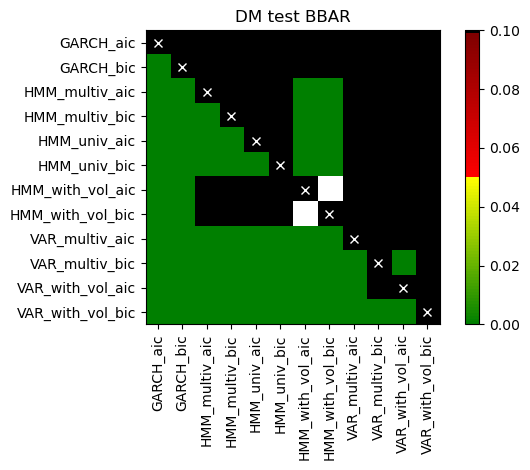

In [42]:
stock="BBAR"
real_values=subset_of_columns(df_test, f"{stock}_log_rets")
forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"__{stock}")
route=os.path.join(graphsroute, "DM", f"""DM_{params["tablename"]}_{stock}.png""")
plot_multivariate_DM_test(real_price=real_values, 
                          forecasts=forecasts.fillna(0), 
                          title=f"DM test {stock}",
                          savefig=True,
                          path=route)

In [59]:
model_list = ["GARCH", "HMM_univ", "HMM_multiv", "VAR_multiv", "VAR_with_vol"]

aggregating_dict = {"aic": {}, "bic": {}}

for criteria, dataframe in zip(("aic", "bic"), (aic_residuals, bic_residuals)):
    for model in model_list:
        aggregating_dict[criteria][model] = subset_of_columns(dataframe, model)

aggregating_dict["bic"]["GARCH"].head()

,GARCH_bic__^MERV,GARCH_bic__GGAL.BA,GARCH_bic__GGAL,GARCH_bic__YPFD.BA,GARCH_bic__YPF,GARCH_bic__EDN.BA,GARCH_bic__EDN,GARCH_bic__BMA.BA,GARCH_bic__BMA,GARCH_bic__BBAR.BA,GARCH_bic__BBAR
2023-06-02,-0.005047,-0.025661,-0.022235,0.007722,0.012681,0.063604,0.100486,-0.001323,0.003509,-0.000395,-0.008184
2023-06-05,0.016250,0.035360,0.038094,0.013768,0.018403,0.086247,0.093646,0.095998,0.042085,-0.000367,0.033212
2023-06-06,0.044891,0.110336,0.111440,0.044727,0.056079,0.003740,0.026269,0.110873,0.132402,-0.000334,0.111272
2023-06-07,-0.005159,0.034746,0.035308,-0.000354,0.002430,-0.014999,-0.031311,0.036467,0.023737,-0.000627,0.034402
2023-06-08,-0.003221,0.018402,0.009482,0.008347,0.003759,0.007923,0.008615,-0.016975,-0.027999,-0.000627,-0.038866


In [63]:
metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

for criteria, dictionary in aggregating_dict.items():
    for model, dataframe in dictionary.items():
        metrics_df.loc["mse", f"{criteria}_{model}"] = (
            (dataframe**2).mean().mean()
        )
        metrics_df.loc["meanabs", f"{criteria}_{model}"] = (
            dataframe.abs().mean().mean()
        )
        metrics_df.loc["medianabs", f"{criteria}_{model}"] = (
            (dataframe.abs()).median().median()
        )

metrics_df = metrics_df * 100
metrics_df

,aic_GARCH,aic_HMM_univ,aic_HMM_multiv,aic_VAR_multiv,aic_VAR_with_vol,bic_GARCH,bic_HMM_univ,bic_HMM_multiv,bic_VAR_multiv,bic_VAR_with_vol
mse,6.653008e+06,0.153527,0.176854,0.293429,0.417043,6.653008e+06,0.171918,0.184005,0.431818,0.460903
meanabs,7.075074e+02,2.899991,3.042162,2.460573,2.844710,7.075155e+02,2.990630,3.096038,3.099160,3.216367
medianabs,2.272801e+00,2.207734,2.220856,1.758667,2.130095,2.284190e+00,2.292984,2.380128,2.227783,2.206785


In [64]:
for criteria in ["aic", "bic"]:
    print(criteria)
    filtered_columns = [col for col in metrics_df.columns if criteria in col]
    for metric in metrics_df.index:
        print(metric)
        print(metrics_df[filtered_columns].loc[metric].idxmin())
        print(np.round(metrics_df[filtered_columns].loc[metric].min(), 5))
        print()
    print()

aic
mse
aic_HMM_univ
0.15353

meanabs
aic_VAR_multiv
2.46057

medianabs
aic_VAR_multiv
1.75867


bic
mse
bic_HMM_univ
0.17192

meanabs
bic_HMM_univ
2.99063

medianabs
bic_VAR_with_vol
2.20679




In [ ]:
DM(p_real=0,)